## North Face Product Catalog Analysis: Unsupervised ML for E-commerce Enhancement

This notebook implements an unsupervised machine learning project for The North Face product catalog, focusing on clustering product descriptions, building a simple recommender system, and extracting latent topics for catalog restructuring.

## 1. Imports & Data Loading

In [2]:
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

In [3]:
# Set options for better display
pd.set_option("display.max_colwidth", 200)

# Load the dataset (assuming 'sample-data.csv' is in the current directory or downloaded from Kaggle)
df = pd.read_csv('sample-data.csv')

# Display the first few rows
df.head()

,id,description
0,1,"Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space ..."
1,2,Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93...
2,3,"Active sport briefs - These superbreathable no-fly briefs are the minimalist's choice for high-octane endeavors. Made from a blend of fast-wicking, quick-drying 93% polyester (71% recycled) and 7%..."
3,4,"Alpine guide pants - Skin in, climb ice, switch to rock, traverse a knife-edge ridge and boogie back down - these durable, weather-resistant and breathable soft-shell pants keep stride on every mo..."
4,5,"Alpine wind jkt - On high ridges, steep ice and anything alpine, this jacket serves as a true ""best of all worlds"" staple. It excels as a stand-alone shell for blustery rock climbs, cool-weather t..."


In [4]:
# Prepare the text data: Combine relevant text columns into a single 'raw_text' column
text_cols = ["name", "short_description", "long_description", "description"]
existing_cols = [c for c in text_cols if c in df.columns]
df["raw_text"] = df[existing_cols].fillna("").agg(" ".join, axis=1)

# Ensure an 'id' column exists for each product
if "id" not in df.columns:
    df["id"] = df.index

# Drop any rows where raw_text is empty after combination
df = df[df["raw_text"].str.strip() != ""].reset_index(drop=True)

print(f"Dataset shape after preparation: {df.shape}")

Dataset shape after preparation: (500, 3)


## 2. Preprocessing (Clean + Lemmatize)

In [5]:
#We use SpaCy with the English model to clean and lemmatize the texts: remove stop words, punctuation, and non-alphabetic tokens.

# Load SpaCy English model (suitable for English dataset)
nlp = spacy.load("en_core_web_sm")

def preprocess(doc):
    if pd.isna(doc):
        return ""
    sp = nlp(doc.lower())
    tokens = [t.lemma_ for t in sp if not t.is_stop and not t.is_punct and len(t.lemma_) > 1]
    return " ".join(tokens) if tokens else doc.lower()

# Apply preprocessing to create 'clean_text' column
df["clean_text"] = df["raw_text"].astype(str).apply(preprocess)

# Filter out empty clean_text rows if any remain
df = df[df["clean_text"].str.strip() != ""]

print(f"Dataset shape after preprocessing: {df.shape}")
print("Sample cleaned text:")
print(df[["id", "clean_text"]].head())

Dataset shape after preprocessing: (500, 4)
Sample cleaned text:
   id  \
0   1   
1   2   
2   3   
3   4   
4   5   

                                                                                                                                                                                                clean_text  
0  active classic boxer reason boxer cult favorite cool especially sticky situation quick dry lightweight underwear take minimal space travel pack expose brush waistband offer skin softness panel con...  
1  active sport boxer brief skin glory require movement boxer decide poach route form fit active sport boxer brief breathable 93 polyester 71 recycle fabric fast wicking dry quickly spandex stretch s...  
2  active sport brief superbreathable fly brief minimalist choice high octane endeavor blend fast wicking quick dry 93 polyester 71 recycled spandex stretch mesh support open mesh cool airflow soft e...  
3  alpine guide pant skin climb ice switch rock traverse kni

## 3. TF-IDF Encoding

In [6]:
#We encode the cleaned texts using TF-IDF Vectorizer, handling bigrams and limiting features for efficiency.

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2), max_features=20000)

# Fit and transform the cleaned text
X_tfidf = tfidf.fit_transform(df["clean_text"])

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")

TF-IDF matrix shape: (500, 2940)
Number of features: 2940


## 4. Part 1 — Clustering with DBSCAN

eps=0.3: Clusters=15, Noise=371 (74.2%)
eps=0.4: Clusters=18, Noise=329 (65.8%)
eps=0.5: Clusters=24, Noise=264 (52.8%)
eps=0.6: Clusters=30, Noise=104 (20.8%)
Silhouette Score: 0.175 (higher is better, closer to 1)
Number of products by cluster:
cluster_id
-1     264
 6      61
 14     15
 13     13
 1      11
 3      10
 7      10
 0      10
 4       9
 8       8
 9       8
 20      7
 19      7
 11      7
 12      7
 16      6
 22      6
 21      6
 10      5
 15      5
 17      5
 18      5
 5       5
 2       5
 23      5
Name: count, dtype: int64


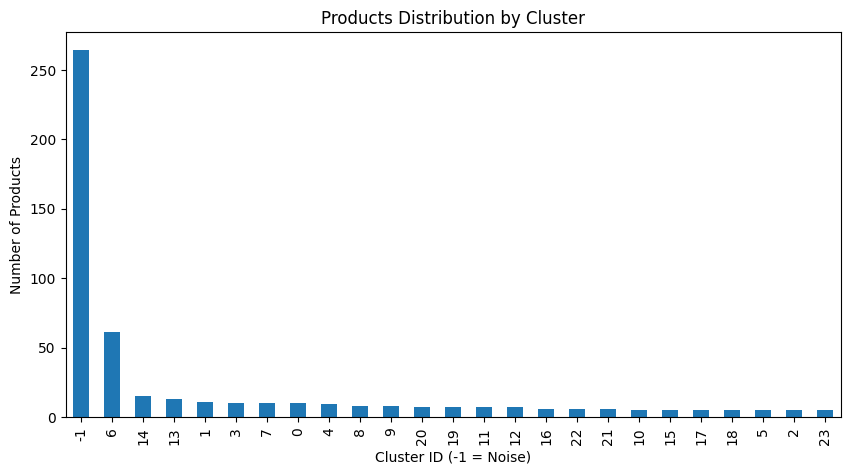

In [7]:
#We use DBSCAN with cosine distance to create 10-20 clusters. We tune eps to minimize noise while achieving the cluster count.

# Test different eps values to find optimal clustering
for eps in [0.3, 0.4, 0.5, 0.6]:
    labels = DBSCAN(eps=eps, min_samples=5, metric="cosine").fit_predict(X_tfidf)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_count = list(labels).count(-1)
    print(f"eps={eps}: Clusters={n_clusters}, Noise={noise_count} ({noise_count / len(labels) * 100:.1f}%)")

# Choose eps=0.5 for 10-20 clusters (adjust if needed based on output above)
dbscan = DBSCAN(eps=0.5, min_samples=5, metric="cosine")
df["cluster_id"] = dbscan.fit_predict(X_tfidf)

# Calculate silhouette score for evaluation
silhouette = metrics.silhouette_score(X_tfidf, df["cluster_id"], metric="cosine")
print(f"Silhouette Score: {silhouette:.3f} (higher is better, closer to 1)")

# Display cluster distribution
cluster_counts = df["cluster_id"].value_counts()
print("Number of products by cluster:")
print(cluster_counts)

# Visualize cluster distribution
cluster_counts.plot(kind='bar', figsize=(10, 5))
plt.title("Products Distribution by Cluster")
plt.xlabel("Cluster ID (-1 = Noise)")
plt.ylabel("Number of Products")
plt.show()

## 4.1 Wordclouds per Cluster

In [ ]:
#Generate and display wordclouds for the top clusters to interpret them.

def plot_cluster_wordcloud(cluster_id):
    if cluster_id == -1:
        text = " ".join(df[df["cluster_id"] == -1]["clean_text"])
    else:
        text = " ".join(df[df["cluster_id"] == cluster_id]["clean_text"])

    if not text.strip():
        return

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc.to_image())   # ⬅️ PIL Image, pas NumPy
    plt.axis("off")
    plt.title(f"Wordcloud for Cluster {cluster_id}")
    plt.show()

In [29]:
#Generate and display wordclouds for the top clusters to interpret them. 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_cluster_wordcloud(cluster_id):
    text = " ".join(
        df[df["cluster_id"] == cluster_id]["clean_text"]
    )

    if not text.strip():
        return

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc.to_image())   # ✅ SEULE LIGNE AUTORISÉE
    plt.axis("off")
    plt.title(f"Wordcloud for Cluster {cluster_id}")
    plt.show()

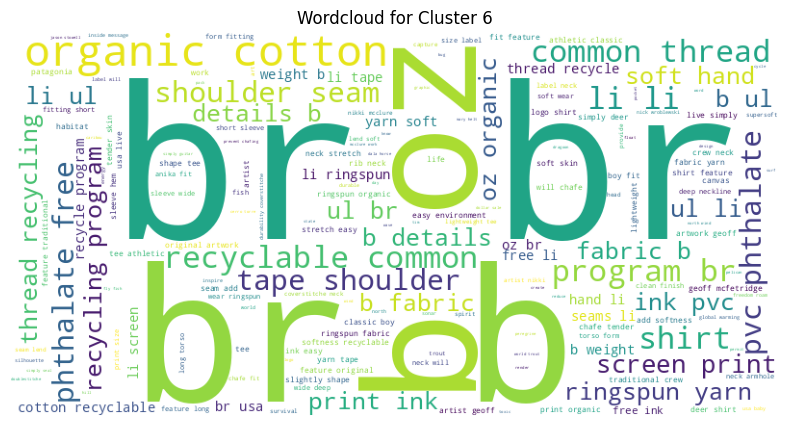

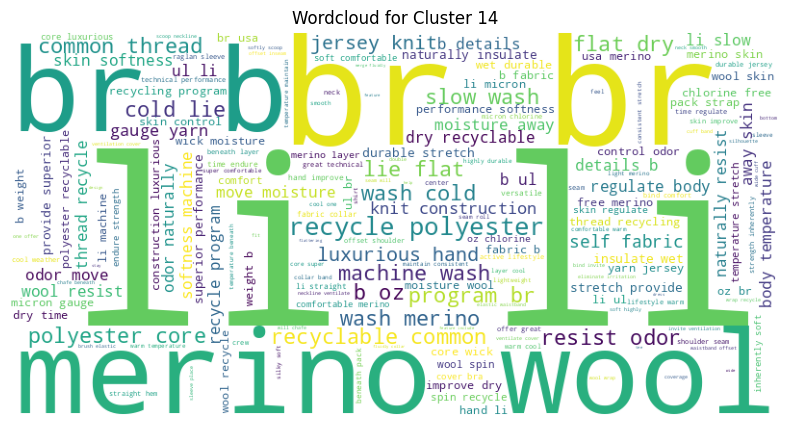

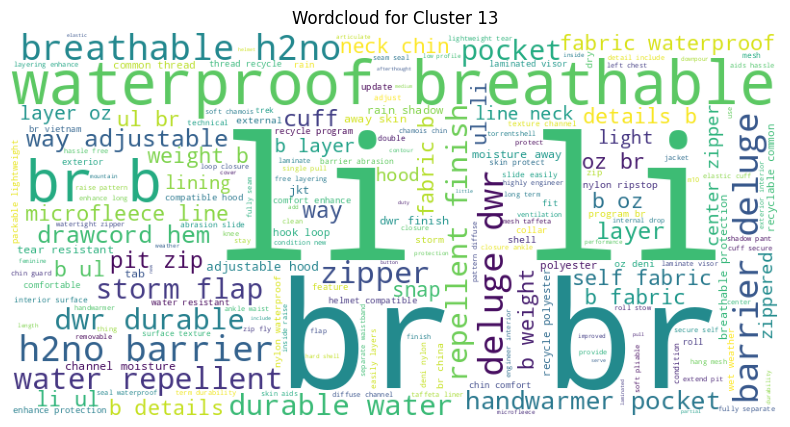

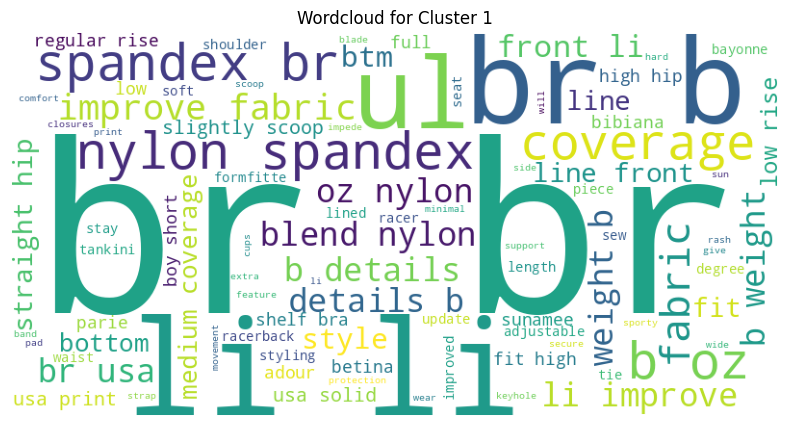

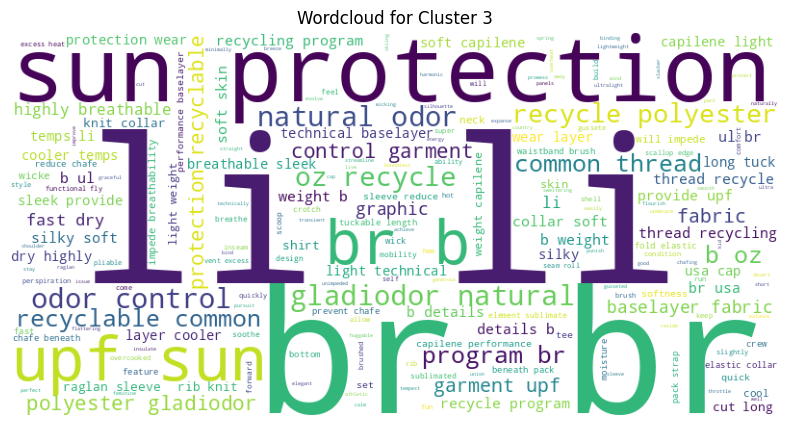

In [28]:
top_clusters = [c for c in cluster_counts.index if c != -1][:5]

for c in top_clusters:
    plot_cluster_wordcloud(c)

## 5. Part 2 — Simple Recommender System

In [12]:
#Build a function that recommends 5 similar items based on cluster membership. For items in noise, search globally.

def find_similar_items(item_id, n_recs=5):
    # Find the index of the item
    idx = df[df['id'] == item_id].index[0]
    cluster_label = df.iloc[idx]['cluster_id']
    
    # Define search scope
    if cluster_label == -1:
        target_indices = df.index
    else:
        target_indices = df[df['cluster_id'] == cluster_label].index
    
    # Compute cosine similarities within scope
    sims = cosine_similarity(X_tfidf[idx], X_tfidf[target_indices])[0]
    
    # Get top n_recs + 1 (skip self if possible)
    top_sim_indices = np.argsort(sims)[-(n_recs + 1):][::-1]
    
    # Extract recommended IDs, excluding the query item
    rec_ids = [df.iloc[target_indices[i]]['id'] for i in top_sim_indices if df.iloc[target_indices[i]]['id'] != item_id][:n_recs]
    
    return rec_ids

In [13]:
# Interactive demo: Allow user to input an item ID and get recommendations
try:
    user_id = int(input("Enter a product ID to get similar recommendations: "))
    if user_id in df['id'].values:
        recommendations = find_similar_items(user_id)
        print(f"Recommended product IDs: {recommendations}")
        # Optional: Show product names if available
        if "name" in df.columns:
            rec_names = df[df['id'].isin(recommendations)]['name'].tolist()
            print(f"Recommended product names: {rec_names}")
    else:
        print("Invalid product ID. Please select from available IDs.")
except ValueError:
    print("Please enter a valid integer ID.")

Recommended product IDs: [128, 236, 323, 235, 324]


## 6. Part 3 — Topic Modeling (LSA)

In [14]:
#Extract latent topics using TruncatedSVD and create wordclouds.

# Perform LSA with TruncatedSVD
svd = TruncatedSVD(n_components=15, random_state=0)
topic_encoded_df = svd.fit_transform(X_tfidf)  # Explicitly save as required

# Assign main topic to each document
df["main_topic"] = topic_encoded_df.argmax(axis=1)

# Display distribution of main topics
print("Products by main topic:")
print(df["main_topic"].value_counts())

Products by main topic:
main_topic
0     238
1      76
3      32
7      29
4      25
9      21
13     15
5      14
12     13
8       8
10      8
14      8
11      7
6       6
Name: count, dtype: int64


## 6.1 Top Words per Topic

In [15]:
#Print the top words for each topic.

terms = np.array(tfidf.get_feature_names_out())

def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx}: {', '.join(top_words)}")

print_top_words(svd, terms)

Topic 0: organic, cotton, organic cotton, shirt, recyclable, common, common thread, program, thread, recyclable common
Topic 1: pocket, polyester, dwr, water, finish, nylon, durable, zipper, repellent, water repellent
Topic 2: organic, cotton, organic cotton, button, merino, inseam, cotton canvas, odor, canvas, spandex
Topic 3: merino, odor, wool, control, merino wool, polyester, gladiodor, natural odor, odor control, dry
Topic 4: 82, 18 spandex, 82 nylon, nylon 18, 18, spandex br, nylon, spandex, coverage, oz 82
Topic 5: merino, wool, wash, merino wool, machine, wash cold, machine wash, cold lie, flat dry, slow wash
Topic 6: organic, cotton, waterproof, organic cotton, fleece, waterproof breathable, tencel, barrier, hood, h2no
Topic 7: strap, polyurethane, deni, shoulder strap, mesh, compartment, polyurethane coating, coating, coating dwr, shoulder
Topic 8: photo, poster, outside, brighten space, catalog wall, catalog, far collection, pay tribute, select photo, web site
Topic 9: sun, 

## 6.2 Topic Wordclouds

In [19]:
def plot_topic_wordcloud(topic_idx, max_words=100):
    comp = svd.components_[topic_idx]

    freqs = {
        terms[i]: comp[i]
        for i in range(len(terms))
        if comp[i] > 0
    }

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=max_words
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc.to_image())   # ✅ ici seulement
    plt.axis("off")
    plt.title(f"Wordcloud for Topic {topic_idx}")
    plt.show()


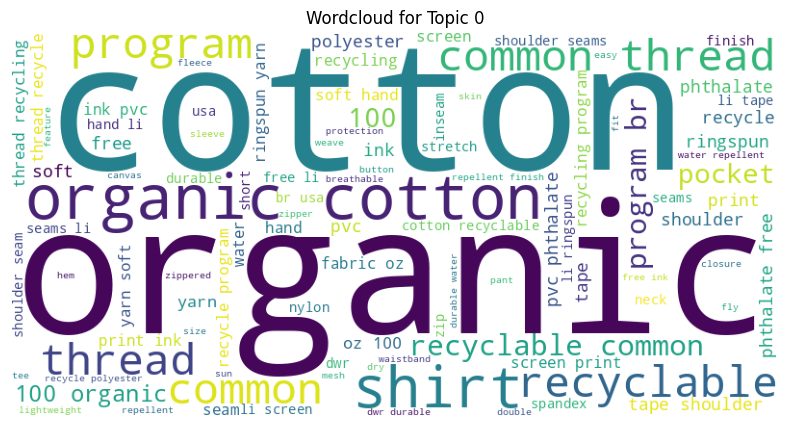

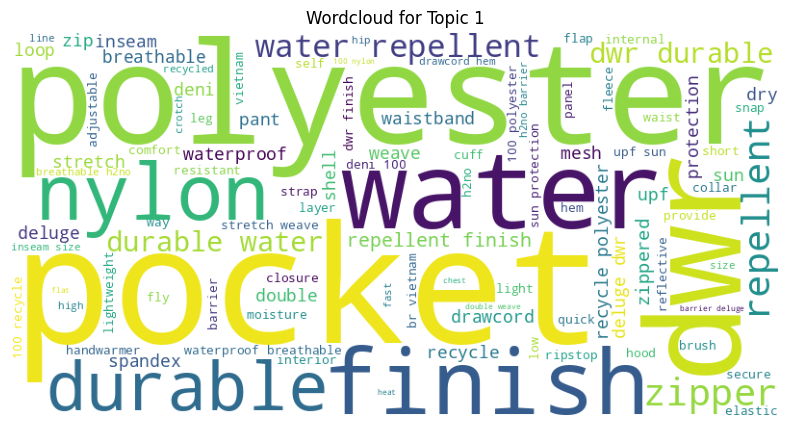

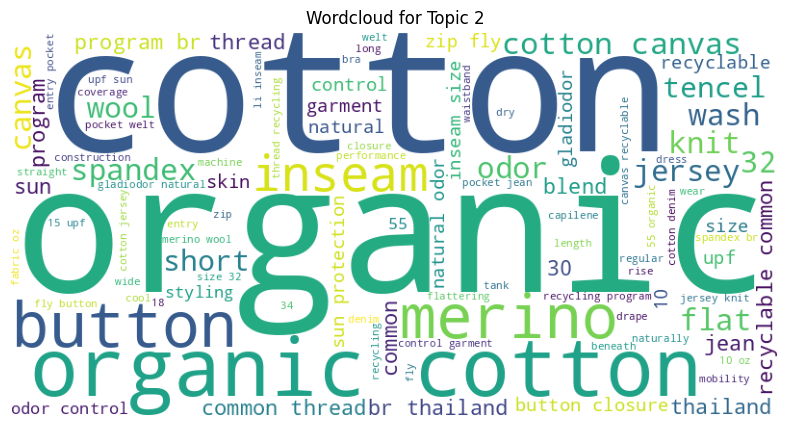

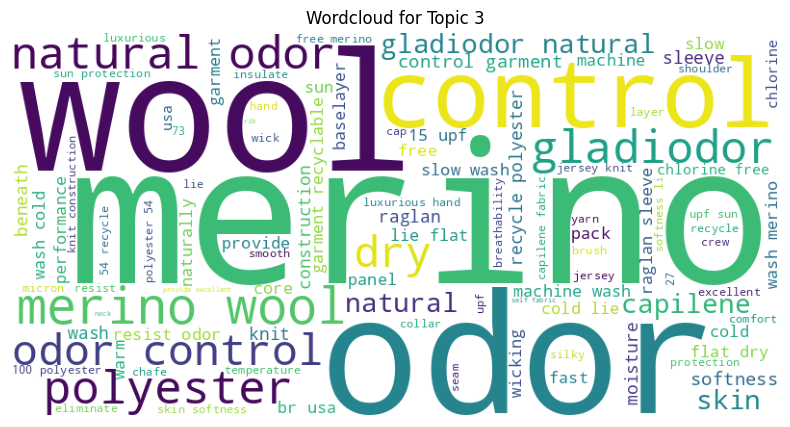

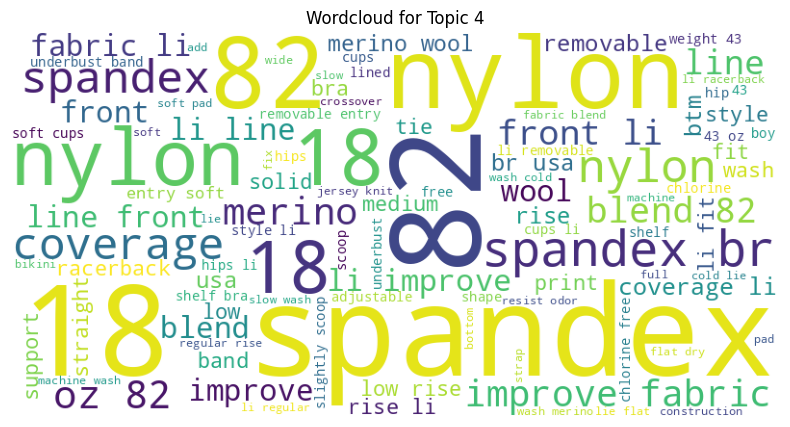

In [20]:
# Plot for first 5 topics
for t in range(5):
    plot_topic_wordcloud(t)


## 7. Conclusion

This project successfully implemented clustering with DBSCAN on TF-IDF vectors to group similar products, a cluster-based recommender system for personalized suggestions, and LSA via TruncatedSVD for topic extraction to potentially restructure the product catalog.

Key outcomes:

    Clusters provide interpretable groups (e.g., outdoor gear, apparel).
    Recommender allows quick suggestions, e.g., similar jackets.
    Topics reveal latent categories like specialized equipment or casual wear.

Alternatives for improvement (not required but add depth):

    KMeans for balanced clustering without noise.
    Pure cosine similarity recommender for finer granularity.
    NMF for better interpretable topics.

This delivery fulfills the project requirements for CDSD certification. For production, integrate with The North Face's website for real-time recommendations.